# PumpItUp
## DrivenDataCompetition PumpItUp
- All data is within the same folder as notebook

In [1]:
import pandas as pd
import matplotlib as plt
import sklearn
import seaborn as sns
import numpy as np

In [2]:
# load training-data and labels
trainingValues = pd.read_csv('4910797b-ee55-40a7-8668-10efd5c1b960.csv')
trainingLabels = pd.read_csv('0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')
trainingData = pd.merge(trainingValues, trainingLabels, on= 'id')

# Investigation on data
Possible data-issues
* population == 0 -> Delete all lines with population == 0
* num_private Not in feature-description -> check what to do with it
* object-data needs to be converted in category-numbers

In [3]:
# delete population == 0
trainingData = trainingData[trainingData.population != 0]


def createCatColumnsWithCodes(data : pd.DataFrame):
    cat_columns = data.select_dtypes(['object']).columns
    if len(cat_columns) == 0:
        return data
    data[cat_columns] = data[cat_columns].astype('category')
    cat_data = data[cat_columns].apply(lambda x: x.cat.codes)
    data = data.join(cat_data, rsuffix='_cat')

    return data

#change labels to category data
trainingData = createCatColumnsWithCodes(trainingData)


In [4]:
# Show data-frame top
trainingData.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality_cat,quality_group_cat,quantity_cat,quantity_group_cat,source_cat,source_type_cat,source_class_cat,waterpoint_type_cat,waterpoint_type_group_cat,status_group_cat
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,6,2,1,1,8,6,0,1,1,0
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,6,2,2,2,5,3,1,1,1,0
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,6,2,1,1,0,1,1,2,1,0
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,6,2,0,0,3,0,0,2,1,2
5,9944,20.0,2011-03-13,Mkinga Distric Coun,0,DWE,39.172796,-4.765587,Tajiri,0,...,4,4,1,1,4,2,2,2,1,0


In [ ]:
# Describe data
trainingData.describe()

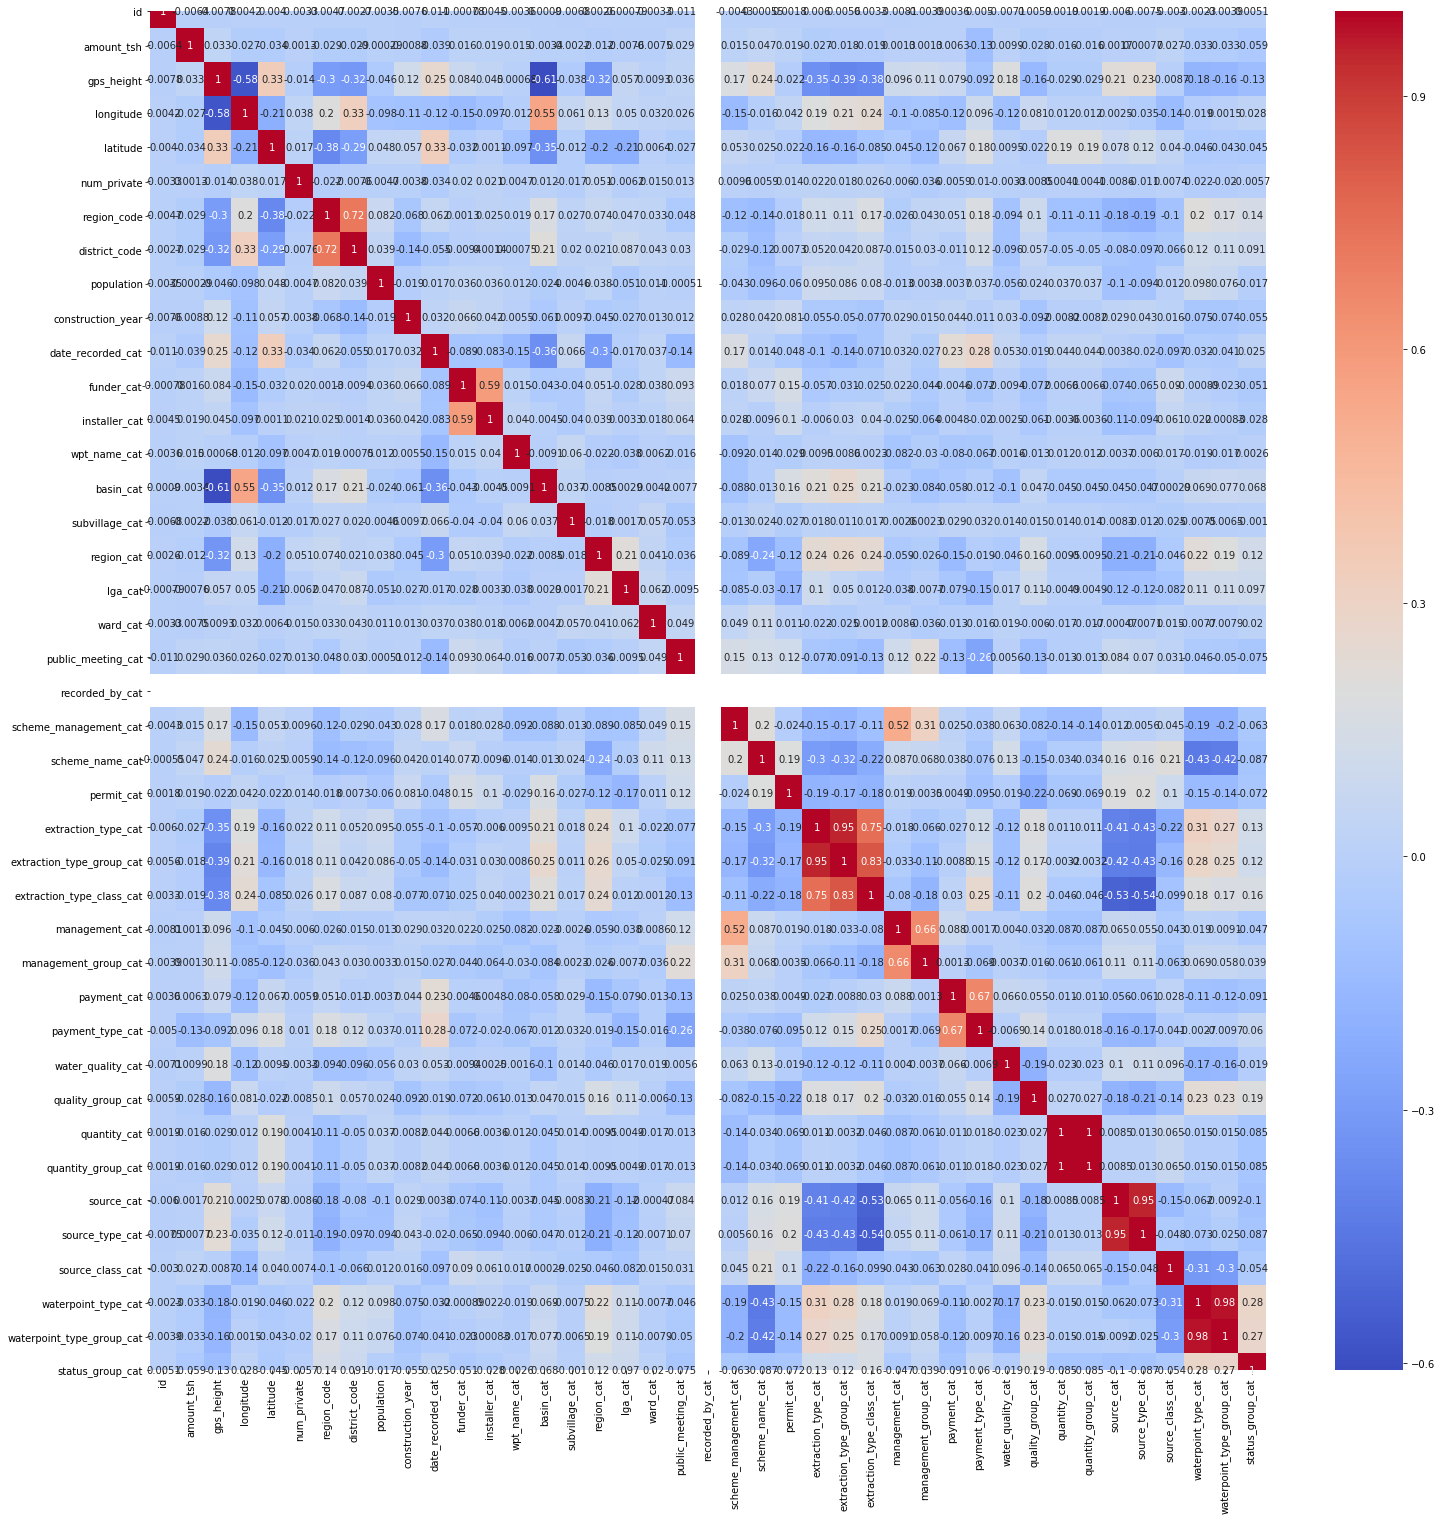

In [11]:
#check correlation
fig = plt.pyplot.gcf()
fig.set_size_inches(25,25)
sns.heatmap(trainingData.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')

In [12]:
print(trainingData.dtypes.unique())

[dtype('int64') dtype('float64')
 CategoricalDtype(categories=['2004-01-07', '2004-03-01', '2004-03-06', '2004-04-01',
                  '2004-05-01', '2004-06-01', '2004-08-01', '2004-09-01',
                  '2004-12-01', '2011-01-03',
                  ...
                  '2013-08-03', '2013-09-02', '2013-09-03', '2013-10-02',
                  '2013-10-03', '2013-11-02', '2013-11-03', '2013-12-01',
                  '2013-12-02', '2013-12-03'],
                 ordered=False)
 CategoricalDtype(categories=['0', 'A/co Germany', 'Abasia', 'Abdul', 'Abood', 'Abs',
                  'Aco/germany', 'Acra', 'Act', 'Act Mara',
                  ...
                  'Yaole', 'Yasi Naini', 'Yasini', 'Yasini Selemani',
                  'Zaburi And Neig', 'Zao', 'Zao Water Spring',
                  'Zao Water Spring X', 'Zinduka', 'Zingibali Secondary'],
                 ordered=False)
 CategoricalDtype(categories=['0', 'ABASIA', 'ABDUL', 'AC', 'ACRA', 'ACT', 'ACT MARA',
                

In [5]:
#split in labels and features
labels = trainingData['status_group_cat']
features = trainingData.drop(['status_group_cat','id'],axis=1)
no_use_columns = features.select_dtypes(['category']).columns
features = features.drop(no_use_columns, axis=1)
features_list = features.columns

#check shapes
print('labels-shape: ' + str(labels.shape))
print('features-shape: ' + str(features.shape))

labels-shape: (38019,)
features-shape: (38019, 39)


In [6]:
from sklearn.model_selection import train_test_split
#split labels and features is train-data and test-data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

#check shape
print('train_features: ', train_features.shape)
print('train_labels: ', train_labels.shape)
print('test_features: ', test_features.shape)
print('test_labels: ', test_labels.shape)

train_features:  (28514, 39)
train_labels:  (28514,)
test_features:  (9505, 39)
test_labels:  (9505,)


# Try random forest


In [7]:

from sklearn.ensemble import RandomForestClassifier


In [8]:
##fit
# create baseline
baseline_preds = 1 # this is 'functional needs repair' - so every pump needs service
baseline_errors = abs(1-test_labels)
print('Baseline_error is: ', round(np.mean(baseline_errors),2))

# train model
randomforest = RandomForestClassifier(n_estimators= 1000, random_state = 42)
randomforest.fit(train_features, train_labels)

Baseline_error is:  0.93


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [9]:
#predict
predictions = randomforest.predict(test_features)


In [10]:
#verify
sklearn.metrics.accuracy_score(test_labels, predictions)

0.8258811152025249

## Try SVC

In [11]:
from sklearn.svm import SVC

In [12]:
classifier = SVC(gamma='scale')

In [14]:
#fit
classifier.fit(train_features, train_labels)

C:\Users\q281368\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [15]:
predictions = classifier.predict(test_features)

In [17]:
sklearn.metrics.accuracy_score(test_labels, predictions)

0.5614939505523409